In [1]:
#Using the MNIST data set to train/test a classifier

#Adding these preparatory steps in order to replicate the results from A.Geron chapter 3

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
import numpy as np
import sklearn

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


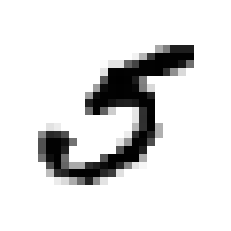

In [6]:
#we can show an image of one of the digits here

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()


In [7]:
y[36000]

#we should see above an image of 5

5

In [8]:
#convert to int units. target is currently a string

import numpy as np

y=y.astype(np.uint8)

In [9]:
#split into training and test

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
#train a binary classifier

#for now, simplify and train it to only detect '5'

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
#try to predict whether the first digit of X is 5

sgd_clf.predict([some_digit])

array([False])

In [12]:
#now evaluate model performance. implement cross-validation. This is essentially sklearns cross_val_score()

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct/len(y_pred))

0.89345
0.75235
0.7899


In [13]:
#try the cross_val_score now

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.89345, 0.75235, 0.7899 ])

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
#When dealing with skewed data, a more appropriate way to assess accuracy is often with a confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[44363, 10216],
       [ 1070,  4351]], dtype=int64)

In [16]:
#the f1 score will be high if both precision and recall of our model are both good.

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.43536121673003797

In [17]:
#we can investigate the threshold for precision in our model

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-101.35360412])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [20]:
threshold = 80000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [21]:
#We can use the cross_val_preict to decide our threshold. Return decision scores instead of precision

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

In [22]:
#now we can use the precision recall curve to compute precision nd recall for all thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
#matplotlib can now plot the precision and recall as functions

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

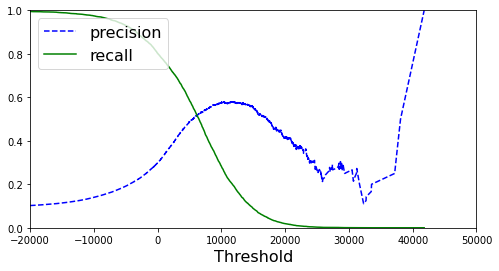

In [29]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-20000, 50000])
plt.show()

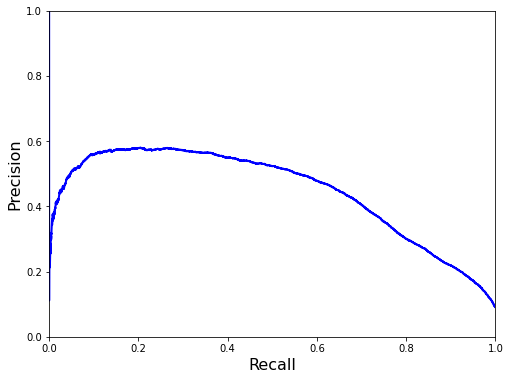

In [30]:
#we can also plot precision directly against recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [32]:
#can search for the lowest value which gives a certain precision. (this model is not v good, just FYI)

threshold_50_precision = thresholds[np.argmax(precisions >= 0.5)]
threshold_50_precision

5514.703527975313

In [37]:
#can use this to make a prediction on the training set

from sklearn.metrics import precision_score, recall_score

y_train_pred_50 = (y_scores >= threshold_50_precision)
precision_score(y_train_5, y_train_pred_50)

0.5

In [38]:
recall_score(y_train_5, y_train_pred_50)

0.5576461907397159

In [39]:
#Now we can look at the ROC curve, which plots true +ve rate vs false +ve rate

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [40]:
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

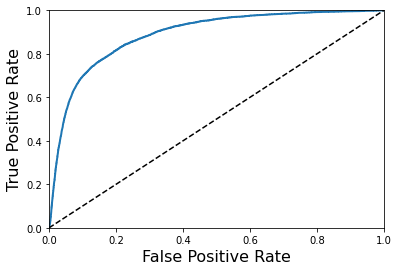

In [41]:
plot_roc_curve(fpr,tpr)
plt.show()

In [42]:
#a good classifier would be as close to the top left as possible. A perfect classifier has area under the curve of 1
#a random classifier will have AUC as 0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.8873322501447319

In [43]:
#now we can try a random forest and check these curves. predict_proba replaces decision_function here

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [44]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

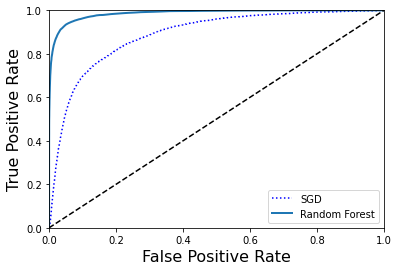

In [48]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [49]:
#clear that the random forest is performing much better, based on this. Confirm with the AUC

roc_auc_score(y_train_5, y_scores_forest)

0.9859689313269965

In [50]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.7967806841046278

In [51]:
recall_score(y_train_5, y_train_pred_forest)

0.8765910348644161

In [53]:
#Try multiclass clssification now using support vector machine

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

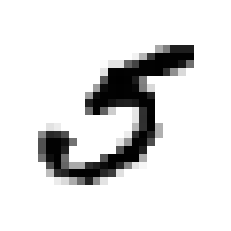

In [57]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

In [55]:
#since this uses OvO classification, we can see the scores for each class/digit

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[7.2857209 , 1.72092862, 5.77012026, 8.29266324, 0.72307597,
        9.31337764, 0.71946817, 4.7416614 , 1.73223991, 3.73632442]])

In [59]:
#can see that other candidates were 0 nd 3.
#check the difference if we force sklearn to use OvR

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [60]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
print(len(ovr_clf.estimators_))

10


In [62]:
#Can also do this with an SGDClssifier. In this case, the SGD classifier directly classifies each instance, 
#so OvO/OvR doesnt matter

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [63]:
#can check the scores assigned to each class by the SGD Classifier

sgd_clf.decision_function([some_digit])

array([[  -382.52170284, -19072.60630422,  -9215.51671077,
         -3736.60589967, -16120.01135804,    274.63843662,
        -18156.66165997,  -7056.62587109, -10653.83889191,
        -10196.1448461 ]])

In [64]:
#all have negative scores except for the winning class. 0 was the next closest.
#can check accuracy aas well.

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87375, 0.8662 , 0.84235])

In [66]:
#not a bad cross val score. Just scale the inputs to see if it will improve

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

C:\Users\Rudy Schneeweiss\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Rudy Schneeweiss\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.90365, 0.89375, 0.9089 ])

In [67]:
#a good increase agin. the lowest score going from ~84 to ~89

#We can now try to analyze the errors that our model is making. Confusion matrix first

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\Rudy Schneeweiss\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Rudy Schneeweiss\miniconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5594,    0,   23,    6,    9,   58,   36,    6,  190,    1],
       [   0, 6414,   38,   26,    6,   47,    4,    8,  186,   13],
       [  28,   27, 5270,   93,   73,   27,   65,   39,  324,   12],
       [  24,   18,  123, 5255,    2,  221,   27,   39,  348,   74],
       [  11,   14,   48,   12, 5236,   12,   36,   25,  270,  178],
       [  29,   16,   31,  171,   55, 4523,   76,   15,  442,   63],
       [  30,   17,   47,    2,   44,  102, 5556,    4,  115,    1],
       [  19,   10,   54,   32,   54,   13,    3, 5714,  148,  218],
       [  18,   66,   47,   89,    4,  135,   24,   11, 5404,   53],
       [  24,   19,   31,   66,  120,   41,    1,  179,  308, 5160]],
      dtype=int64)

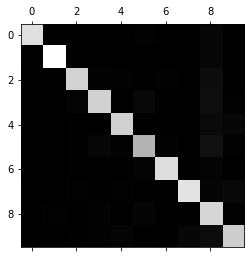

In [68]:
#matshow can visualize this better

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

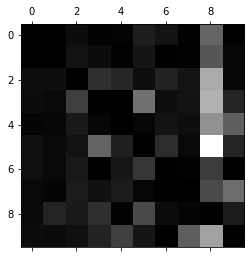

In [69]:
#need to find error rates rather than numbers of errors

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

#fill diagonaal to keep only the errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [75]:
#From this confusion matrix, we can see that many images are misclassified as 8
#3 and 5 are also often confused. 4 and 7 often are confused with 9

#plot some examples of 3, 5 


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [76]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

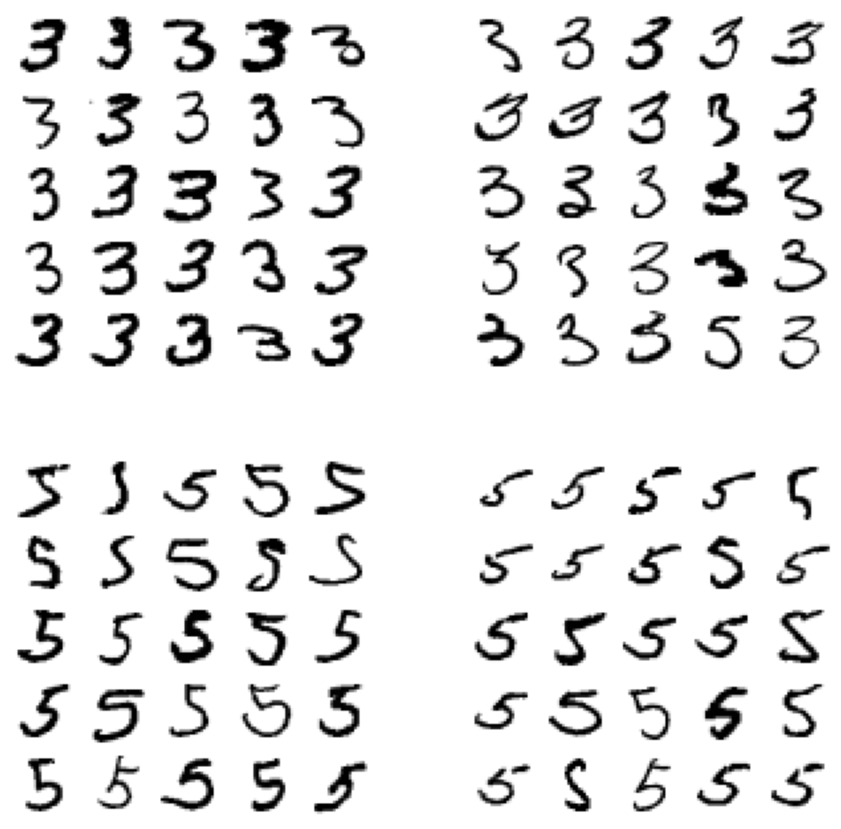

In [77]:
plt.figure(figsize=(15,15))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

In [78]:
#images on the left classified as 3, images on the right classified as 5

#Now try a multilabel classifier

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [79]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [80]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [81]:
#KNN arrives at the correct prediction. 5 is odd and is not large

y_train_knn_pred =  cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.23978719361580844

In [85]:
#multioutput classification next. We want to remove noise from images

#add random noise to the test/training set

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

#targets will be the original images

y_train_mod = X_train
y_test_mod = X_test

In [87]:
#want to check the data post adding the noise.
#function to plot single digit this time

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

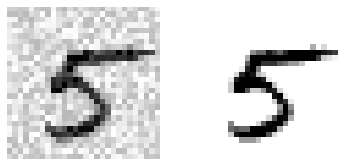

In [90]:
some_index = 5500

plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

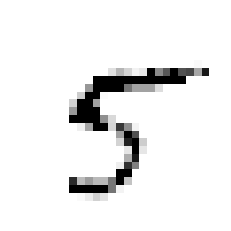

In [91]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)